<a href="https://colab.research.google.com/github/sm354/COL870-Assignment-1/blob/main/2_1BILSTM_NER_GMB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize

# import psutil
# import humanize
# import os
# import GPUtil as GPU

# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#     process = psutil.Process(os.getpid())
#     print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
#     print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader, TensorDataset
import io

if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu"  

# device = "cpu"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pretrained = "glove" # glove or random
char_embeds = "Yes"

In [6]:
# reading text file in python and making list of sentences (list of lists) and list of tags(list of lists)
def load_data(datapath, buildvocab_tags= True, vocab = None, nertags = None):
    if(buildvocab_tags == True):
        all_words = []
        all_tags = []
        with open(datapath) as f:
            lines = f.readlines()
            sent_num = 0
            for line in lines[1:]: #1: so that the first blank line isn't taken into account
                if(line == "\n"):
                    sent_num+=1
                else:
                    line_sep = line.split(sep = " ")
                    all_words.append(line_sep[0])
                    all_tags.append(line_sep[3][:-1])
                    
        words = list(set(all_words))
        tags = list(set(all_tags))

        vocab = {}
        vocab['<pad>'] = 0 # for padding input sequences
        vocab['<oov>'] = 1
        for i, word in enumerate(words):
            vocab[word] = i+2
            
        nertags = {}
        nertags['padtag'] = 0
        for i,nertag in enumerate(tags):
            nertags[nertag] = i+1

    train_sent = []
    train_tags = []
    with open(datapath) as f:
        lines = f.readlines()
        sent_num = 0
        sentence = []
        tag = []
        for line in lines[1:]: #1: so that the first blank line isn't taken into account
            if(line == "\n"):
                sent_num+=1
                train_sent.append(sentence)
                train_tags.append(tag)
                sentence = []
                tag = []
            else:
                line_sep = line.split(sep = " ")
                if(line_sep[0] in vocab.keys()):
                    sentence.append(vocab[line_sep[0]])
                else:
                    sentence.append(vocab['<oov>'])
                    
                tag.append(nertags[line_sep[3][:-1]])

    # padding the sentences at the end
    seq_maxlen = max(len(x) for x in train_sent)
    x_lengths = [len(x) for x in train_sent]
    Xtrain = []
    Ytrain = []
    for sent, tags in zip(train_sent, train_tags):
        length_toappend = seq_maxlen - len(sent)
        Xtrain.append(sent+[0]*length_toappend)
        Ytrain.append(tags+[0]*length_toappend)


    Xtrain = torch.Tensor(Xtrain)
    Ytrain = torch.Tensor(Ytrain)
    x_lengths = torch.Tensor(x_lengths)
    # print(Xtrain.shape, Ytrain.shape, x_lengths.shape)
    
    return Xtrain, Ytrain, x_lengths, vocab, nertags

### Training Data
### using dataloader to make data batches

In [7]:
traindatapath = "/content/drive/MyDrive/Q2_DL/train.txt"
devdatapath = "/content/drive/MyDrive/Q2_DL/dev.txt"

Xtrain, Ytrain, x_trainlengths, vocab, nertags = load_data(traindatapath, buildvocab_tags=True)
Xdev, Ydev, x_devlengths, _, _ = load_data(devdatapath, buildvocab_tags=False, vocab = vocab, nertags = nertags)

traindataset = TensorDataset(Xtrain, Ytrain, x_trainlengths)
Trainloader = DataLoader(traindataset, batch_size= 128, shuffle=True)

devdataset = TensorDataset(Xdev, Ydev, x_devlengths)
Devloader = DataLoader(devdataset, batch_size = 128)

In [4]:
embedding_size = 100
if(pretrained == "glove"):
    gloveembeddings_index = {}
    with io.open("/content/drive/MyDrive/Q2_DL/glove.6B.100d.txt", encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:],dtype='float32')
            gloveembeddings_index[word] = coefs

    #using vocab and Xtrain, Xvalid, get pretrained glove word embeddings
    glove_embeds = np.zeros((len(vocab), embedding_size))
    for word in vocab.keys():
        if(word in gloveembeddings_index.keys()):
            # for the pad word let theembedding be all zeros
            glove_embeds[vocab[word]] = gloveembeddings_index[word]
        else:
            glove_embeds[vocab[word]] = np.random.randn(embedding_size)
    word_embeds = torch.Tensor(glove_embeds)
    # print(glove_embeds.shape) # shape (vocablength , embedding dim)

if(pretrained == "random"):
    num_words = len(vocab)
    word_embeds = torch.rand(num_words, embed_dim)

# hence we get word_embeds which we could use afterwards

In [ ]:
if(char_embeds = "Yes"):
    charmodel = train_charmodel(train)

In [99]:
#weight matrix for cross entropy loss
weight = torch.zeros([len(nertags)])
for i in range(len(nertags)):
    weight[i] = 1/((Ytrain.view(-1) == i).sum())
# print(weight)

tensor([3.2724e-07, 3.4200e-05, 4.4248e-03, 7.5426e-05, 7.5426e-05, 4.4248e-03,
        7.0423e-03, 2.5641e-02, 3.3784e-03, 6.3279e-05, 6.3424e-05, 1.7498e-04,
        1.4512e-06, 1.9775e-04, 5.2910e-03, 7.5188e-03, 7.6214e-05, 8.2932e-05])


# LSTM models for character **level**

In [ ]:
class forwardLSTM(nn.Module)
    def __init__(self, embedding_size, hidden_size, pretr_char_embed):
        super(forwardLSTM, self).__init__()
        self.charembed = nn.Embedding.from_pretrained(pretr_char_embed, freeze = True) #size of pretrained = (totalchars,embedding size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, dropout = 0.5, bidirectional = False, batch_first = True)

    def forward(self, xchar):
        #xchar is of shape(batchsize, seqlen, maxwordlen-ie max char = 6)
        out = []
        for i in range(xchar.shape[1])

        #(batchsize, seqlen, embeddingsize = 25)


class backLSTM(nn.Module)
    def __init__(self):
        super(forwardLSTM, self).__init__()

    def forward(self, xchar):

# BiLSTM Model

In [103]:
class BiLSTM(nn.Module):
    def __init__(self, embedding_size, hidden_size, total_words, num_class, pretrained = False, pretrained_embed = None):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        
        # self.wordembed = nn.Embedding(total_words, embedding_size) #weights initiallized from std normal dist, randomly
        # if(pretrained == True):
        #     self.wordembed.weight = nn.Parameter(pretrained_embed) #pretrained embeds have size (total_words, embedding_size)

        self.wordembed = nn.Embedding.from_pretrained(pretrained_embed, freeze = True)
        self.for_charembed = forwardLSTM()
        self.back_charembed = bachwardLSTM()

        self.bilstm = nn.LSTM(embedding_size + 50,hidden_size, dropout = 0.5, bidirectional = True, batch_first = True)
        self.linear = nn.Linear(2*hidden_size, num_class) # 2 because forward and backward concatenate

    def forward(self, x, xchar, xlengths):
        word_embedding = self.wordembed(x) # x is of size(batchsize, seq_len), out is of size (batchsize, seq_len, embedding_size = 100)
        forwardchar= self.for_charembed(xchar) #forwardchar and backwardchar would be of size (batchsize, seqlen. embedding_size = 25each) 
        backwardchar = self.back_charembed(xchar)
        out = torch.cat((word_embedding, forwardchar, backwardchar), dim = 2)

        # out = pack_padded_sequence(out, xlengths.cpu(), batch_first=True, enforce_sorted=False)
        
        out, (h,c) = self.bilstm(out) #'out' has dimension(batchsize, seq_len, 2*hidden_size)
        
        # out, out_lengths = pad_packed_sequence(out, batch_first=True)

        out = self.linear(out) #now 'out' has dimension(batchsize, seq_len, num_class)
        out = out.view(-1, out.shape[2]) # shape (128*seqlen, 18)
        out = F.log_softmax(out, dim=1) # take the softmax across the dimension num_class, 'out' has dimension(batchsize, seq_len, num_class)
        return out
        
        

In [104]:
model = BiLSTM(embedding_size = 100, hidden_size = 100, total_words = len(vocab), num_class = 18, pretrained = True, pretrained_embed = glove_embeds).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3) 
lossfunction = nn.CrossEntropyLoss(weight = weight)

# print(model)
def accuracy(y, ypred, nertags):
    y = y.numpy()
    ypred = ypred.numpy()
    mask = (y != nertags['padtag']) * (y != nertags['O'])
    # print(mask.sum())
    # print(mask)
    y = y*mask
    ypred = ypred*mask
    acc = ((y==ypred)*mask).sum()/mask.sum()
    return acc

# def lossfunction(ypred, yactual):
#     mask_padded = (yactual!=nertags['padtag']).float()
#     logprobs = ypred[:, yactual]
#     logprobs = logprobs*mask_padded
#     num = (yactual!=nertags['padtag']).sum().item()
#     return -torch.sum(logprobs)/num

def validate(model, loader):
    with torch.no_grad():
        validloss = 0
        acc = 0
        i = 0
        for step, (X, Y, xlen) in enumerate(loader):
            ypred = model(X.long().to(device), xlen.to(device))#.permute(0, 2, 1)
            vloss = lossfunction(ypred.to('cpu'), Y.view(-1).type(torch.LongTensor))
            validloss+=vloss
            acc_ = accuracy(Y.view(-1), torch.argmax(ypred.to('cpu'), dim = 1), nertags)
            acc+=acc_
            i+=1

    return validloss/i, acc/i

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [105]:
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.001) 
trainloss = []
validloss = []
acclist = [] #accuracy except pad, O
valacclist = []

In [112]:
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9) 

In [113]:
# Model is ready now we have to train using cross entropy loss
num_epochs = 100
# validloss = []
model.train()
for epoch in range(num_epochs):
    if(epoch == 10):
      model.wordembed.weight.requires_grad = True
    for step, (Xbatch ,Ybatch, xbatch_len) in enumerate(Trainloader):
        #make gradients 0
        optimizer.zero_grad()
        # print(Xbatch.shape)
        
        #get output from model and claculate loss
        ypred = model(Xbatch.long().to(device), xbatch_len.to(device))#.permute(0, 2, 1)
        if(step%1000 == 0):
            # print(ypred.shape, Ybatch.shape)
            acc = accuracy(Ybatch.view(-1), torch.argmax(ypred.to('cpu'), dim = 1), nertags)
            print("accuracy = {}".format(acc))
            acclist.append(acc)
        
        loss = lossfunction(ypred.to('cpu'), Ybatch.view(-1).type(torch.LongTensor)) #Ybatch has dimension (batchsize, seqlen), ypred has dimension(batchsize, num_classes, seqlen)
        
        #backward and step
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5) # clip gradient to 5
        optimizer.step()
    
    trainloss.append(loss)
    # model validation loss and scheduler step for learning rate change if required
    val_loss, val_acc = validate(model, Devloader)
    validloss.append(val_loss)
    valacclist.append(val_acc)
    scheduler.step(val_loss)
    print('\nepoch = {}, training_loss = {}, validation_loss = {}'.format(epoch, trainloss[-1], validloss[-1]))        
        
        
        

accuracy = 0.8069767441860465

epoch = 0, training_loss = 0.25071361660957336, validation_loss = 1.0424443483352661
accuracy = 0.8093023255813954

epoch = 1, training_loss = 0.4421331584453583, validation_loss = 1.05917489528656
accuracy = 0.8326180257510729

epoch = 2, training_loss = 0.30962640047073364, validation_loss = 1.0555262565612793
accuracy = 0.7909090909090909

epoch = 3, training_loss = 0.5047191977500916, validation_loss = 1.0505092144012451
accuracy = 0.7954545454545454

epoch = 4, training_loss = 0.4159138798713684, validation_loss = 1.0583398342132568
accuracy = 0.7837837837837838

epoch = 5, training_loss = 0.3818749487400055, validation_loss = 1.066270351409912
accuracy = 0.7780429594272077

epoch = 6, training_loss = 0.33888372778892517, validation_loss = 1.0631229877471924
accuracy = 0.8131067961165048

epoch = 7, training_loss = 0.4743479788303375, validation_loss = 1.0566062927246094
accuracy = 0.7991071428571429

epoch = 8, training_loss = 0.2748398780822754, va

KeyboardInterrupt: ignored

In [114]:
print(trainloss)
print(acclist)

[tensor(1.8262, grad_fn=<NllLossBackward>), tensor(1.7313, grad_fn=<NllLossBackward>), tensor(1.1247, grad_fn=<NllLossBackward>), tensor(0.7176, grad_fn=<NllLossBackward>), tensor(0.7206, grad_fn=<NllLossBackward>), tensor(0.8368, grad_fn=<NllLossBackward>), tensor(1.0982, grad_fn=<NllLossBackward>), tensor(0.7484, grad_fn=<NllLossBackward>), tensor(0.9695, grad_fn=<NllLossBackward>), tensor(0.6556, grad_fn=<NllLossBackward>), tensor(0.7988, grad_fn=<NllLossBackward>), tensor(0.6737, grad_fn=<NllLossBackward>), tensor(0.6650, grad_fn=<NllLossBackward>), tensor(0.4299, grad_fn=<NllLossBackward>), tensor(0.4433, grad_fn=<NllLossBackward>), tensor(0.5393, grad_fn=<NllLossBackward>), tensor(0.5148, grad_fn=<NllLossBackward>), tensor(0.5604, grad_fn=<NllLossBackward>), tensor(0.3638, grad_fn=<NllLossBackward>), tensor(0.5430, grad_fn=<NllLossBackward>), tensor(0.4363, grad_fn=<NllLossBackward>), tensor(0.3378, grad_fn=<NllLossBackward>), tensor(0.3410, grad_fn=<NllLossBackward>), tensor(0.2

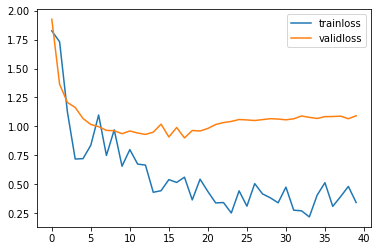

In [115]:
plt.plot(trainloss, label = "trainloss")
plt.plot(validloss, label = "validloss")
plt.legend()
plt.show()

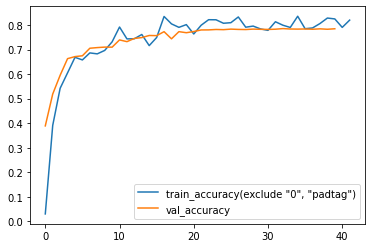

In [117]:
plt.plot(acclist, label = 'train_accuracy(exclude "0", "padtag")')
plt.plot(valacclist, label = 'val_accuracy')
plt.legend()
plt.show()